In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objects as go


In [246]:
df = pd.read_csv("/content/Inflation Rates.csv")
df.info()
df.head(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      224 non-null    int64  
 1   Month                     224 non-null    object 
 2   Annual Average Inflation  224 non-null    float64
 3   12-Month Inflation        224 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 7.1+ KB


,Year,Month,Annual Average Inflation,12-Month Inflation
0,2023,July,8.68,7.28
1,2023,June,8.77,7.88
2,2023,May,8.78,8.03
3,2023,April,8.71,7.90
4,2023,March,8.59,9.19
5,2023,February,8.30,9.23
6,2023,January,7.95,8.98


In [66]:
df.isnull().sum()

Year                        0
Month                       0
Annual Average Inflation    0
12-Month Inflation          0
dtype: int64

In [67]:
df.head()

,Year,Month,Annual Average Inflation,12-Month Inflation
0,2023,July,8.68,7.28
1,2023,June,8.77,7.88
2,2023,May,8.78,8.03
3,2023,April,8.71,7.90
4,2023,March,8.59,9.19


In [68]:
df['Month'].unique()

array(['July', 'June', 'May', 'April', 'March', 'February', 'January',
       'December', 'November', 'October', 'September', 'August'],
      dtype=object)

In [69]:
df['Year'].unique()

array([2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013,
       2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005])

In [247]:
month_to_number = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].map(month_to_number).astype(str), format='%Y-%m')

df.drop(['Year', 'Month'], axis=1, inplace=True)
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=True)

print(df.head())


            Annual Average Inflation  12-Month Inflation
Date                                                    
2005-01-01                     12.27               14.87
2005-02-01                     12.60               13.94
2005-03-01                     13.07               14.15
2005-04-01                     13.76               16.02
2005-05-01                     14.61               14.78


In [248]:
def parse_data_from_dataframe(df):
    date = []
    inflation = []

    count = 0
    for rate in df['12-Month Inflation']:
        inflation_float = float(rate)
        inflation.append(inflation_float)
        date.append(int(count))
        count += 1

    return date, inflation

In [249]:
dates, inflation = parse_data_from_dataframe(df)
date = np.array(dates)
series = np.array(inflation)
split_time = 156
window_size = 10
batch_size = 5
shuffle_buffer_size = 32

[]

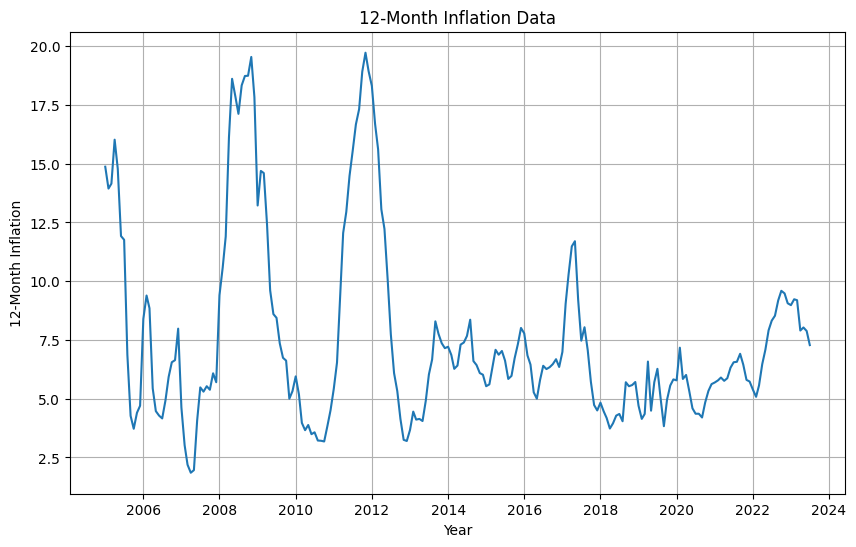

In [250]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["12-Month Inflation"])
plt.xlabel('Year')
plt.ylabel('12-Month Inflation')
plt.title(f'12-Month Inflation Data')
plt.grid(True)
plt.plot()

In [251]:
def train_val_split(time, series, time_step):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_trainset, time_valid, series_validset = train_val_split(df.index, series, split_time)

In [253]:
time_train

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01'],
              dtype='datetime64[ns]', name='Date', length=156, freq=None)

In [254]:
#function to create a window from the dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    data = []
    for i in range(len(series) - window_size):
        data.append(series[i:i+window_size+1])
    data = np.array(data)

    X = data[:, :-1]
    y = data[:, -1]

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(shuffle_buffer).batch(batch_size).prefetch(1)

    return dataset

In [255]:
training_data = windowed_dataset(series_trainset,window_size, batch_size , shuffle_buffer_size)


In [257]:
len(training_data)

30

In [258]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1,
                               activation='relu', input_shape=[window_size,1]),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(1),
    ])

    return model

In [259]:
#checking whether the predicted label and the actual label y have the same shape
def test_model_prediction(training_data):
    for X_batch, y_batch in training_data.take(1):  # Take one batch
        print("Input (X) Batch:")
        print(X_batch)

        uncompiled_model = create_uncompiled_model()
        y_batch = y_batch.numpy().squeeze()
        print("Target (y) Batch:")
        print(y_batch)
        print("\n")

        print(f'Testing model prediction with input of shape {X_batch.shape}...')
        y_pred = uncompiled_model.predict(X_batch)

        y_pred_shape = y_pred.squeeze().shape

        assert y_pred_shape == y_batch.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                               f'whereas actual y shape = {y_batch.shape}.')

        break

    print("Your current architecture is compatible with the windowed dataset! :)")


test_model_prediction(training_data)

Input (X) Batch:
tf.Tensor(
[[11.92 11.76  6.87  4.27  3.72  4.4   4.7   8.39  9.39  8.85]
 [ 3.02  2.19  1.85  1.96  4.07  5.48  5.3   5.53  5.38  6.08]
 [ 4.07  5.48  5.3   5.53  5.38  6.08  5.7   9.4  10.58 11.9 ]
 [ 4.16  4.92  5.93  6.55  6.64  7.98  4.63  3.02  2.19  1.85]
 [ 5.53  5.38  6.08  5.7   9.4  10.58 11.9  16.12 18.61 17.87]], shape=(5, 10), dtype=float64)
Target (y) Batch:
[ 5.44  5.7  16.12  1.96 17.12]


Testing model prediction with input of shape (5, 10)...
1/1 [==============================] - 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


In [17]:
def adjust_learning_rate(dataset):

    model = create_uncompiled_model()

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

    optimizer = 'adam'
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])


    history = model.fit(dataset,epochs=100, callbacks=[lr_schedule])

    return history


lr_history = adjust_learning_rate(training_data)

Epoch 1/100
30/30 [==============================] - 10s 9ms/step - loss: 6.4232 - mae: 6.9232 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 0s 8ms/step - loss: 5.6139 - mae: 6.1139 - lr: 1.1220e-04
Epoch 3/100
30/30 [==============================] - 0s 8ms/step - loss: 2.1450 - mae: 2.5955 - lr: 1.2589e-04
Epoch 4/100
30/30 [==============================] - 0s 8ms/step - loss: 1.8763 - mae: 2.3254 - lr: 1.4125e-04
Epoch 5/100
30/30 [==============================] - 0s 8ms/step - loss: 1.6773 - mae: 2.1018 - lr: 1.5849e-04
Epoch 6/100
30/30 [==============================] - 0s 8ms/step - loss: 1.6663 - mae: 2.0975 - lr: 1.7783e-04
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 1.7290 - mae: 2.1581 - lr: 1.9953e-04
Epoch 8/100
30/30 [==============================] - 0s 8ms/step - loss: 1.7523 - mae: 2.1861 - lr: 2.2387e-04
Epoch 9/100
30/30 [==============================] - 0s 8ms/step - loss: 1.7450 - mae: 2.1821 - lr: 2.5119e-04


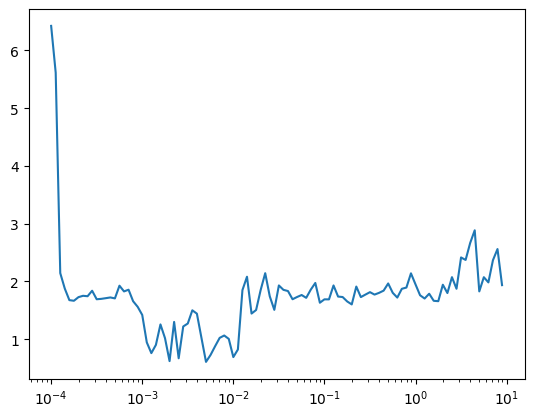

In [18]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.show()

In [260]:
def create_model():
    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae"])

    # Define the EarlyStopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=30, restore_best_weights=True)

    return model, early_stopping

In [261]:
# Save an instance of the model
model, early_stopping= create_model()
history = model.fit(training_data, epochs=500, callbacks =[early_stopping])

Epoch 1/500
30/30 [==============================] - 8s 17ms/step - loss: 3.8202 - mae: 4.2837
Epoch 2/500
30/30 [==============================] - 0s 8ms/step - loss: 2.7073 - mae: 3.1369
Epoch 3/500
30/30 [==============================] - 0s 9ms/step - loss: 2.5512 - mae: 2.9670
Epoch 4/500
30/30 [==============================] - 0s 9ms/step - loss: 2.0375 - mae: 2.4631
Epoch 5/500
30/30 [==============================] - 0s 8ms/step - loss: 1.1852 - mae: 1.6212
Epoch 6/500
30/30 [==============================] - 0s 10ms/step - loss: 0.8548 - mae: 1.2575
Epoch 7/500
30/30 [==============================] - 0s 9ms/step - loss: 0.8223 - mae: 1.2189
Epoch 8/500
30/30 [==============================] - 0s 9ms/step - loss: 0.7457 - mae: 1.1471
Epoch 9/500
30/30 [==============================] - 0s 9ms/step - loss: 0.5995 - mae: 0.9741
Epoch 10/500
30/30 [==============================] - 0s 9ms/step - loss: 0.8084 - mae: 1.2081
Epoch 11/500
30/30 [==============================] - 0s 

In [262]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

def plot_series(time, series, format="-", start=0, end=None, label = None, color = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def val_model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

7/7 [==============================] - 1s 15ms/step


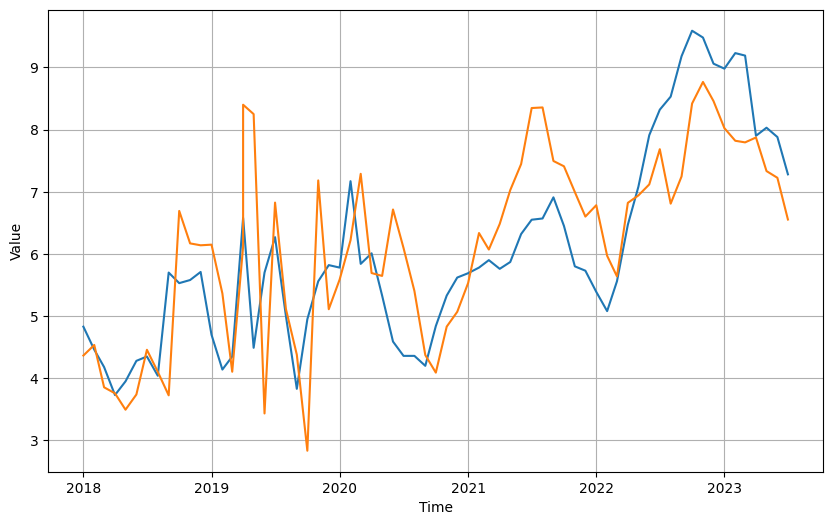

In [263]:
#plotting predicted values vs actual values of the validation data
forecast = val_model_forecast(model, series, window_size).squeeze()
model_forecast = forecast[split_time - window_size:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_validset)
plot_series(time_valid, model_forecast)

In [264]:
mse, mae = compute_metrics(series_validset, model_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1.28, mae: 0.89 for forecast


In [265]:
from google.colab import files

model.save('model.h5')
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [266]:
def future_model_forecast(model, series, window_size, future_steps):
    # Prepare the dataset for prediction
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(5).prefetch(1)

    # Predict using the model
    forecast = model.predict(dataset)

    # Extract predictions for future time steps
    future_forecast = []

    for batch in forecast:
        future_forecast.extend(batch[-future_steps:])

    return np.array(future_forecast).squeeze()

In [273]:
def plot_future_forecast(model, series, time_valid, window_size, future_months):
    last_timestamp = time_valid[-1]
    future_time_steps = future_months
    future_time = pd.date_range(start=last_timestamp, periods=future_time_steps, freq='1M')
    future_forecast = future_model_forecast(model, series, window_size, future_time_steps)
    fig = go.Figure()
    fig.add_trace(go.Scattergl(x=time_valid, y=series, mode='lines', name='Actual Data', line=dict(color='salmon')))

    fig.add_trace(go.Scattergl(x=future_time, y=future_forecast, mode='lines', name='Predicted Data (Future)', line=dict(color='green')))

    fig.update_layout(title='Actual vs. Predicted Data', xaxis_title='Time', yaxis_title='Value')
    fig.show()

In [275]:

future_months = 36
plot_future_forecast(model, series, time_valid, window_size, future_months)

43/43 [==============================] - 0s 7ms/step
